## Import required packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

## Import data from AWS and prepare for processing

In [2]:
df = pd.read_csv('https://mod4finalproject.s3.amazonaws.com/zillow_cleaned_no_nulls.csv',
                   index_col=0,
                   dtype = {'zip':'object'})

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['regionid', 'zip', 'city', 'state', 'metro', 'countyname', 'sizerank',
       'value'],
      dtype='object')

In [5]:
df = df.drop(columns = ['regionid', 'city', 'state', 'metro', 'countyname', 'sizerank'])

In [6]:
d2011 = '2011-05-01'
d2018 = '2018-04-01'

In [7]:
df = df[d2011:d2018]

## Define top 5 zip codes

In [8]:
top_zips = ['33976', '33974', '47353', '71263', '67860']

In [9]:
df = df.loc[df.zip.isin(top_zips)]

## Define functions for use in analysis

In [11]:
def plot_zip(df,zipcode, start, end):
    """
    Parameters:
    """
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    sns.lineplot(x=zip_df.index, y=zip_df.value)
    return plt.show()

In [12]:
def plot_diff(df, zipcode, start, end, lag):
    zip_df = df.loc[df['zip'] == zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)] 
    zip_df['diff'] = zip_df.value - zip_df.value.shift(lag)
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    plot = sns.lineplot(x=zip_df.index, y=zip_df['diff'])
    return plt.show()

In [13]:
def get_zip_df(df, zipcode, start, end):
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    return zip_df

In [14]:
def get_diff_df(df, zipcode, start, end, lag):
    diff_df = df.loc[df['zip'] == zipcode]
    diff_df = diff_df.loc[(diff_df.index >= start) & (diff_df.index <= end)] 
    diff_df['diff'] = diff_df.value - diff_df.value.shift(lag)
    diff_df = diff_df.dropna(axis=0)
    return diff_df

In [15]:
## Test functions
# diff_df(df, top_zips[0], d2011, d2018, 2)

In [16]:
## Test functions
# for z in top_zips:
#     diff_plot(df, z, d2011, d2018, 1)

## Analysis for Lehigh Acres, FL 33974

In [82]:
zipcode = '33974'
start = d2011
end = d2018
lag = 1
lehigh = get_zip_df(df, zipcode, start, end)

### Plot of values, monthly

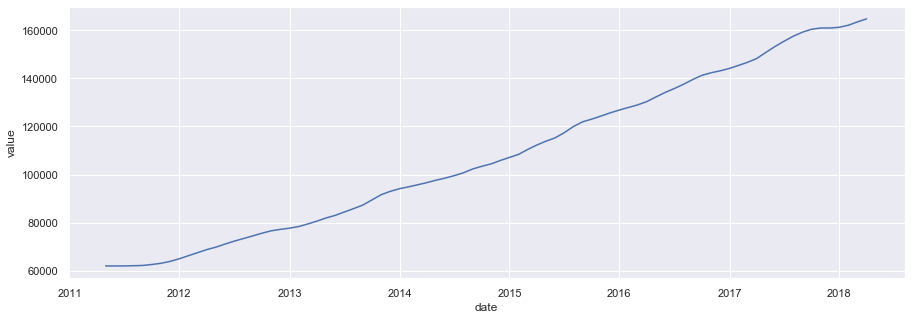

In [18]:
plot_zip(df, zipcode, start, end)

### Decomposition

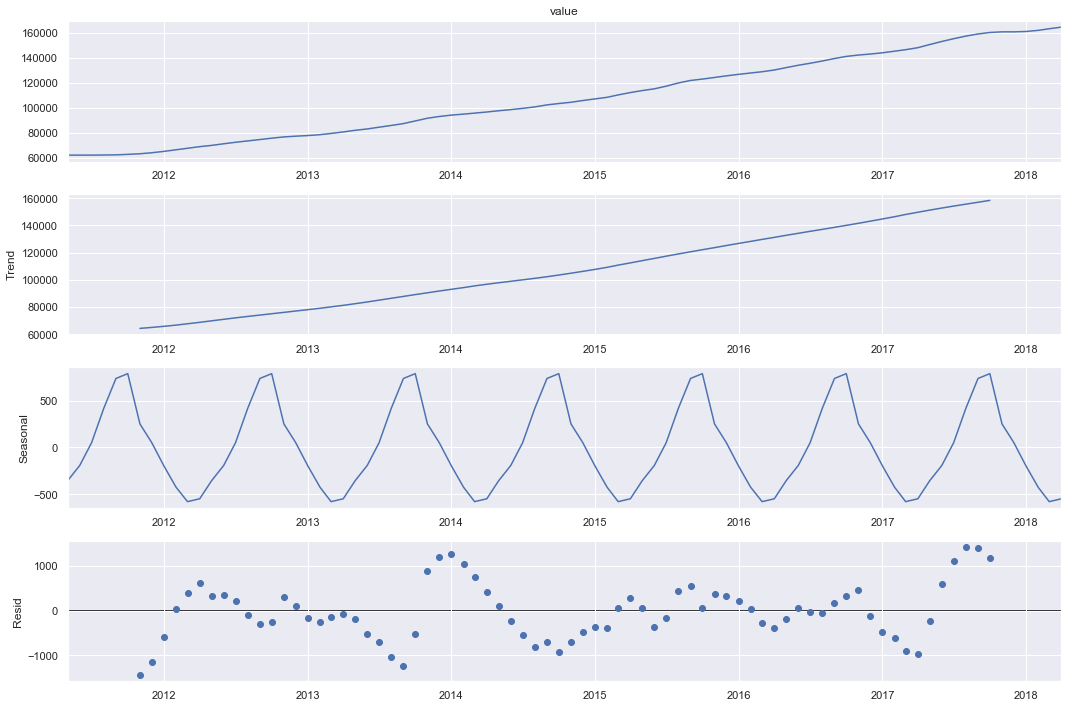

In [20]:
rcParams['figure.figsize'] = (15, 10)
result = seasonal_decompose(lehigh.value, model='additive')
result.plot()
plt.show()

### Plot of difference from lag

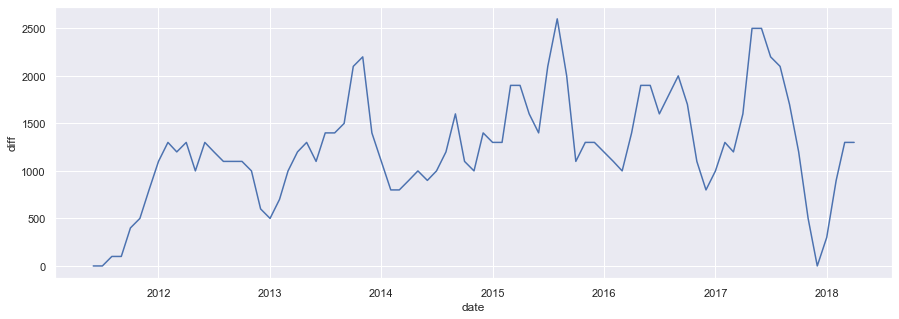

In [21]:
plot_diff(df, zipcode, start, end, lag)

### ACF and PACF for lag values

In [22]:
diff_df = get_diff_df(df, zipcode, start, end, lag)

### ACF (Pandas)

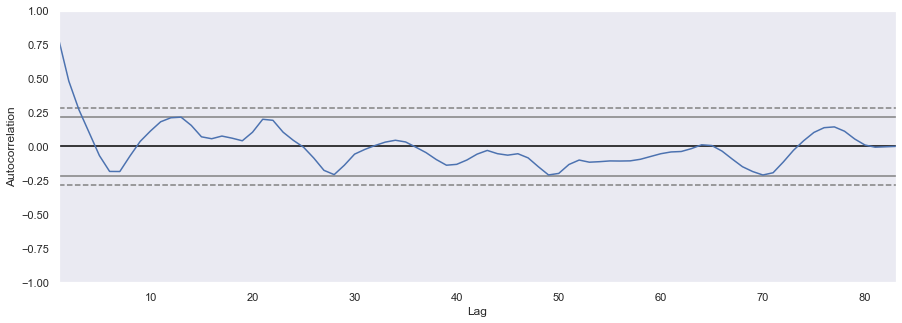

In [23]:
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(diff_df['diff']);

### ACF (statsmodel)

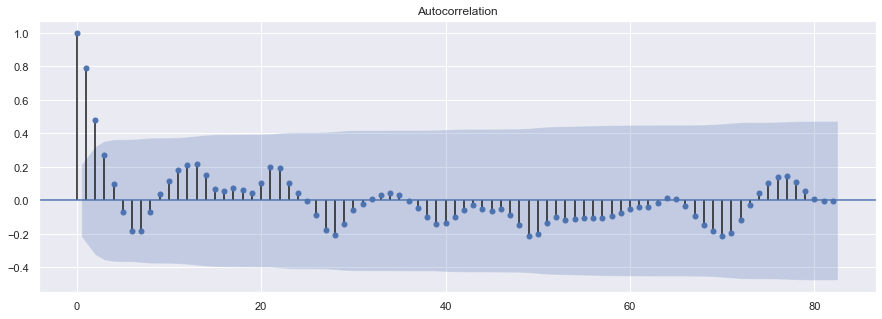

In [24]:
rcParams['figure.figsize'] = 15, 5
plot_acf(diff_df['diff'], lags=82);

### PACF (statsmodel)

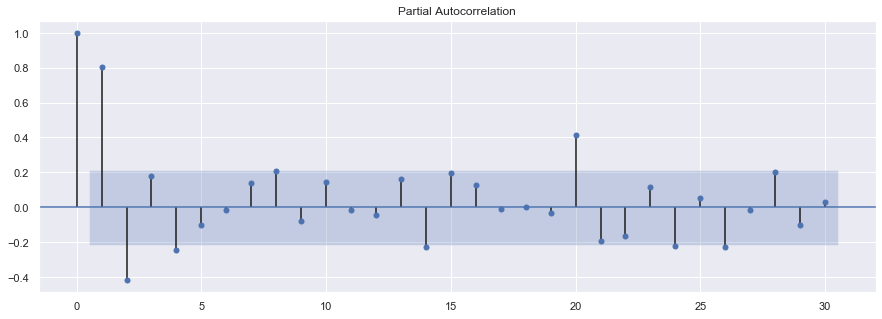

In [25]:
rcParams['figure.figsize'] = 15, 5
plot_pacf(diff_df['diff'], lags=30);

### Import train, val, test

In [78]:
pickle_in = open('../data/processed/train_val_test.pickle', 'rb')
train_val_test = pickle.load(pickle_in)

train = train_val_test[0]
val = train_val_test[1]
test = train_val_test[2]

In [79]:
train = train.loc[train.zip == zipcode]
val = val.loc[val.zip == zipcode]
test = test.loc[test.zip == zipcode]

In [80]:
train = pd.concat([train, val])

### ARIMA model
Looks like an AR(1) model based on ACF/PACF

In [48]:
model = ARIMA(train.value, order=(3,2,1))
model_fit = model.fit(disp=0)
model_fit.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.value   No. Observations:                   58
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -409.219
Method:                       css-mle   S.D. of innovations            279.449
Date:                Thu, 07 May 2020   AIC                            830.439
Time:                        20:11:24   BIC                            842.801
Sample:                    07-01-2011   HQIC                           835.254
                         - 04-01-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.8680     29.973      0.796      0.426     -34.879      82.615
ar.L1.D2.value    -0.7017      0.166     -4.230      0.000      -1.027      -0.377
ar.L2.D2.value    -0.2167      0.149     -1.450      0.147      -0.510       0.076
ar.L3.D2.value    -0.3919      0.123     -3.191      0.001      -0.633      -0.151
ma.L1.D2.value     0.8688      0.128      6.786      0.000       0.618       1.120
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0808           -0.0000j            1.0808           -0.5000
AR.2            0.2640           -1.5138j            1.5366           -0.2225
AR.3            0.2640           +1.5138j            1.5366            0.2225
MA.1           -1.1510           +0.0000j            1.1510            0.5000
-----------------------------------------------------------------------------
"""

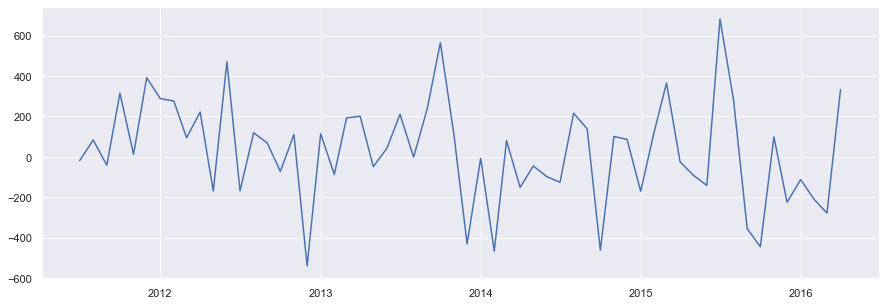

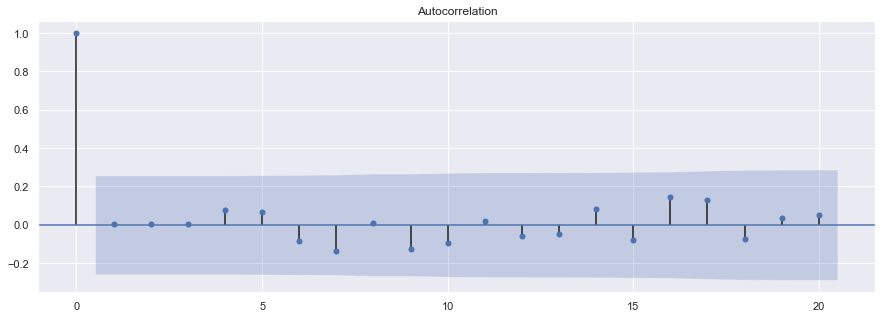

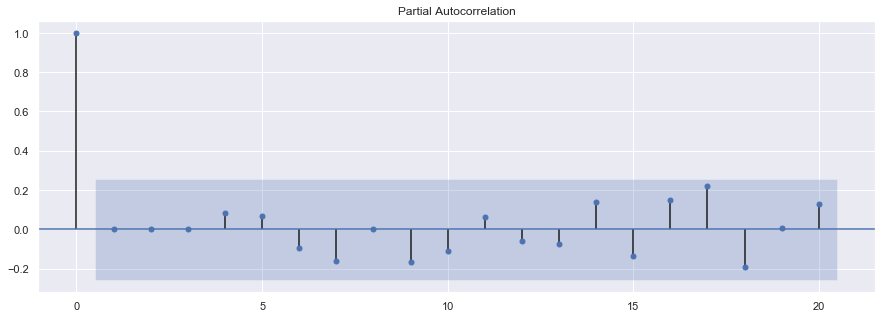

In [31]:
resid = model_fit.resid
plt.plot(resid)
plt.show()
rcParams['figure.figsize'] = 15, 5
plot_acf(resid, lags=20)
plt.show()
plot_pacf(resid, lags=20)
plt.show()

In [70]:
test_pred = model_fit.forecast(steps=24)[0]

RMSE for Test Period: 2372.9335896582456


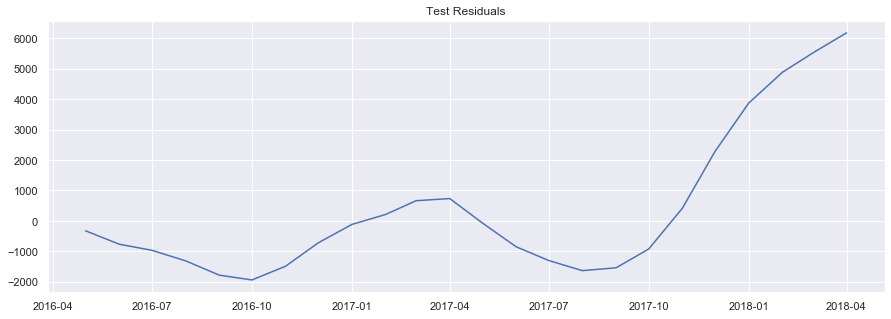

In [71]:
test_resid = test_pred - test.value
rmse = sqrt(mean_squared_error(test.value, test_pred))
print('RMSE for Test Period: {}'.format(rmse))
plt.plot(test_resid)
plt.title('Test Residuals')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


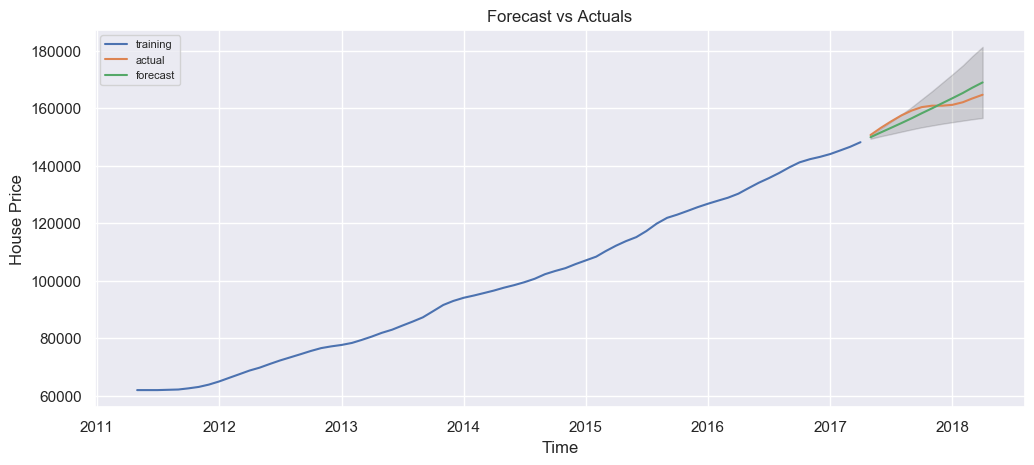

In [93]:
model = ARIMA(train['value'], order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['value'], label='training')
plt.plot(test['value'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.xlabel('Time')
plt.ylabel('House Price')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('/Users/josephmchugh/Pictures/Mod4_Plots/lehigh_forecast_test.png')
plt.show()

In [89]:
train.tail()

,zip,value
date,,
2016-12-01,33974,143100.0
2017-01-01,33974,144100.0
2017-02-01,33974,145400.0
2017-03-01,33974,146600.0
2017-04-01,33974,148200.0


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


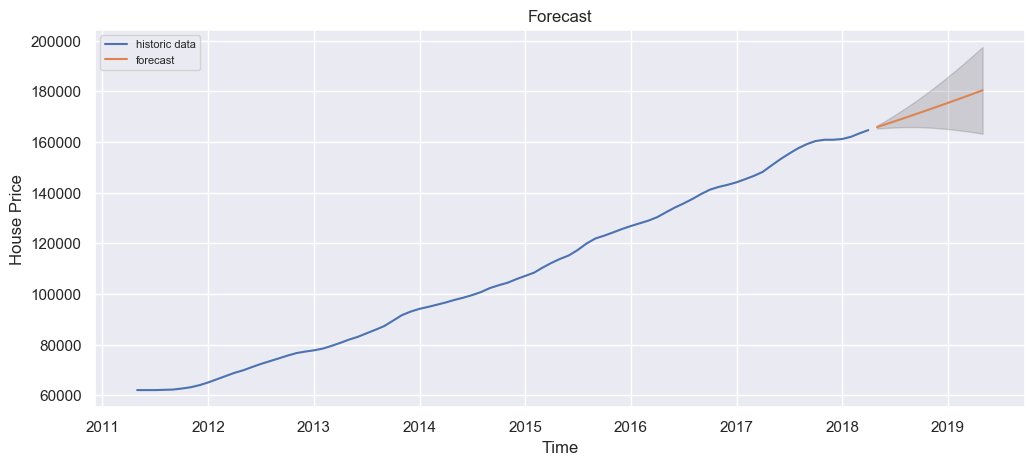

In [94]:
model = ARIMA(lehigh['value'], order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=pd.date_range('2018-05-01', '2019-05-01',12))
lower_series = pd.Series(conf[:, 0],index=pd.date_range('2018-05-01', '2019-05-01',12))
upper_series = pd.Series(conf[:, 1],index=pd.date_range('2018-05-01', '2019-05-01',12))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(lehigh['value'], label='historic data')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.xlabel('Time')
plt.ylabel('House Price')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('/Users/josephmchugh/Pictures/Mod4_Plots/lehigh_forecast_act.png')
plt.show()

In [99]:
perc_uncert = (upper_series[-1]-lower_series[-1])/lehigh.value[-1]
perc_uncert

0.20824521987559266

In [100]:
pos_uncert = (upper_series[-1] - lehigh.value[-1]) / lehigh.value[-1]
pos_uncert

0.19961016625411368

In [101]:
neg_uncert = np.abs(lower_series[-1]-lehigh.value[-1]) / lehigh.value[-1]
neg_uncert

0.008635053621478974

In [109]:
uncert_ratio = pos_uncert/neg_uncert

In [104]:
growth = np.log(fc_series[-1]) - np.log(fc_series[0])

In [106]:
sharpe = growth / perc_uncert

In [107]:
print('Sharpe: {}'.format(sharpe))

Sharpe: 0.40283505137356385


In [110]:
print('Weighted Sharpe {}'.format(sharpe*uncert_ratio))

Weighted Sharpe 9.312040793545094
